In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from os import path
sns.set()
import datetime as dt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

In [3]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from keras.preprocessing import sequence
from keras.layers import Conv1D, Flatten,MaxPooling1D
from keras.preprocessing import text
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# Importing the csv data files 
data = pd.read_csv('sarcasm.csv')
data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
# Data Pre-Processing
# Removing the null comments
data.dropna(subset=['comment'], inplace=True)
data['comment'] = data['comment'].str.lower()
data['comment'] = data['comment'].str.replace('[^\w\s]','')

In [6]:
# Converting the timestamp into DateTime object
data.created_utc = pd.to_datetime(data.created_utc)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   label           1010773 non-null  int64         
 1   comment         1010773 non-null  object        
 2   author          1010773 non-null  object        
 3   subreddit       1010773 non-null  object        
 4   score           1010773 non-null  int64         
 5   ups             1010773 non-null  int64         
 6   downs           1010773 non-null  int64         
 7   date            1010773 non-null  object        
 8   created_utc     1010773 non-null  datetime64[ns]
 9   parent_comment  1010773 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 84.8+ MB


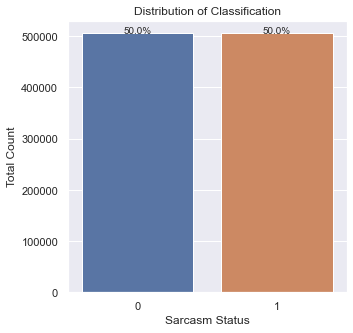

In [7]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x='label', data=data)
ax.set(title="Distribution of Classification", xlabel="Sarcasm Status", ylabel="Total Count")
total = float(len(data))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.1f}%'.format((height / total) * 100), ha="center") 
plt.show()

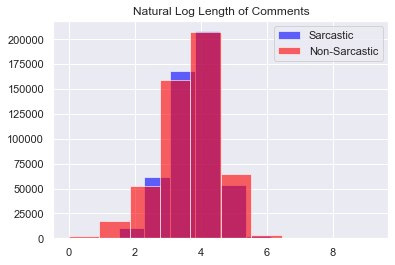

In [8]:
data['log_comment'] = data['comment'].apply(lambda text: np.log1p(len(text)))
data[data['label'] == 1]['log_comment'].hist(alpha=0.6, label='Sarcastic', color='blue')
data[data['label'] == 0]['log_comment'].hist(alpha=0.6, label='Non-Sarcastic', color='red')
plt.legend()
plt.title('Natural Log Length of Comments')
plt.show()

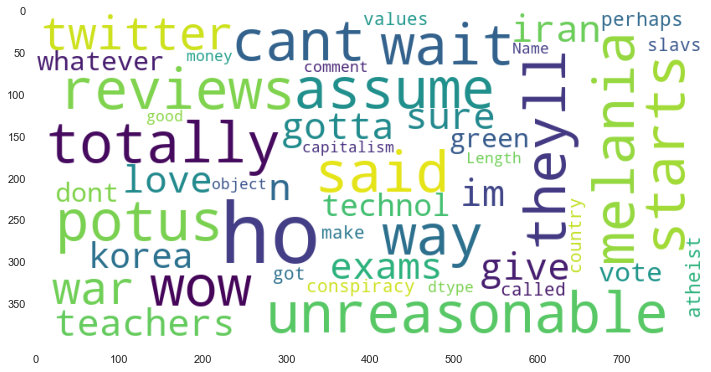

In [9]:
wordcloud = WordCloud(background_color='white', stopwords=STOPWORDS, max_words=200, max_font_size=100, random_state=24, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(data.loc[data['label'] == 1, 'comment']))
plt.grid(b=False)
plt.imshow(wordcloud);

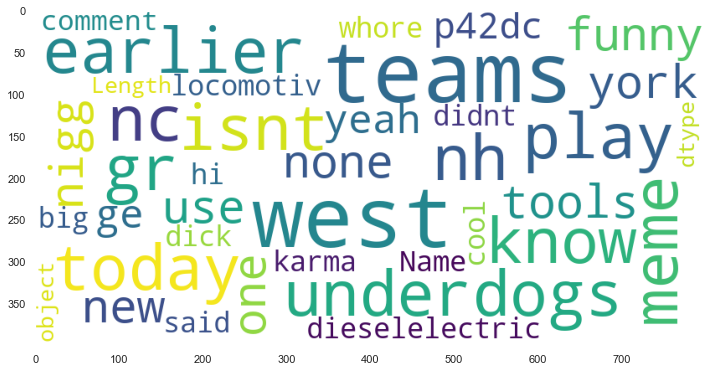

In [10]:
plt.figure(figsize=(12, 12))
wordcloud.generate(str(data.loc[data['label'] == 0, 'comment']))
plt.grid(b=False)
plt.imshow(wordcloud);

In [11]:
sarcasm_comm_len = np.array(data.loc[data['label'] == 1]['comment'].str.len())
parent_comm_len = np.array(data.loc[data['label'] == 1]['parent_comment'].str.len())
ratio_len = np.array((data.loc[data['label'] == 1]['comment'].str.len())/(data.loc[data['label'] == 1]['parent_comment'].str.len()))

In [12]:
dataset = pd.DataFrame({'Comment Length': sarcasm_comm_len, 'Parent Comment Length': parent_comm_len, 'Ratio Length': ratio_len}, 
                       columns=['Comment Length', 'Parent Comment Length', 'Ratio Length'])

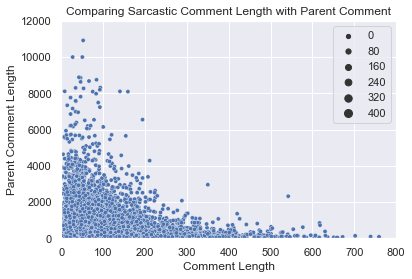

In [13]:
ax = plt.axes()
sns.scatterplot(data=dataset, x="Comment Length", y="Parent Comment Length",  size=ratio_len)
ax.set_title("Comparing Sarcastic Comment Length with Parent Comment")

plt.ylim(0, 12000)
plt.xlim(0, 800)
plt.show()

In [14]:
# Getting the top 5 popular subreddits
data['subreddit'].value_counts()[:5]

AskReddit          65674
politics           39493
worldnews          26376
leagueoflegends    21034
pcmasterrace       18987
Name: subreddit, dtype: int64

In [15]:
top_reddits =['AskReddit', 'politics', 'worldnews', 'leagueoflegends', 'pcmasterrace']

In [16]:
subreddit = pd.DataFrame()
subreddit['subreddit'] = top_reddits
subreddit['sarcastic'] = np.nan
subreddit['natural'] = np.nan
subreddit['total'] = np.nan

In [17]:
# Calculating the count of Sarcastic and Natural comments for the top 5 subreddits 
for i in range(len(top_reddits)):
    temp = data.loc[data['subreddit'] == subreddit.subreddit.iloc[i]]
    length = len(temp)
    count_sarcastic = len(temp.loc[temp['label'] == 1])
    subreddit.sarcastic.iloc[i] = count_sarcastic
    subreddit.natural.iloc[i] = length - count_sarcastic
    subreddit.total.iloc[i] = length

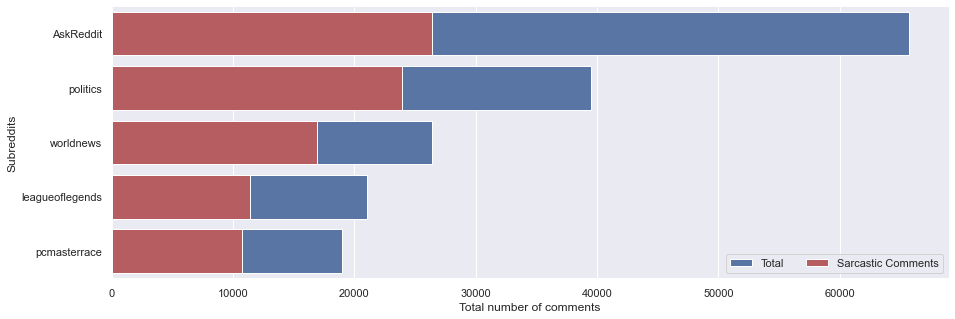

In [18]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 5))

# Plot the total comments for the subreddits
sns.barplot(x="total", y="subreddit", data=subreddit, label="Total", color="b")

# Plot the total sarcastic comments for the subreddits
sns.barplot(x="sarcastic", y="subreddit", data=subreddit, label="Sarcastic Comments", color="r")
ax.legend(ncol=2, loc="lower right", frameon=True)

ax.set(ylabel="Subreddits", xlabel="Total number of comments")
sns.despine(left=True, bottom=True)

In [19]:
# Feature Engineering- Extracting the day of a week
data['created_utc'] = pd.to_datetime(data['created_utc'], format='%d/%m/%Y %H:%M:%S')
data['Day of Week'] = data['created_utc'].dt.day_name()

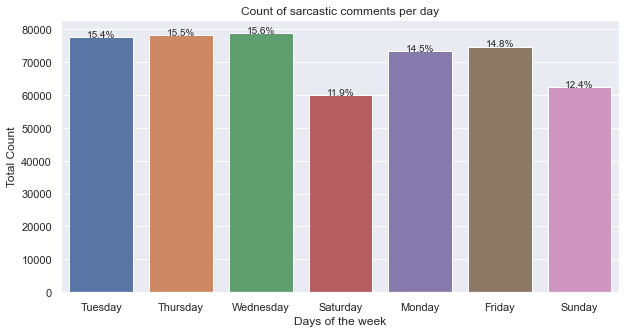

In [20]:
# Visualization of Column- label
plt.figure(figsize=(10,5))
ax = sns.countplot(x='Day of Week',  data=data.loc[data['label']==1])
ax.set(title = "Count of sarcastic comments per day", xlabel="Days of the week", ylabel="Total Count")
total = float(len(data))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 7,
            '{:1.1f}%'.format((height/total)*100*2),
            ha="center") 
plt.show()

In [21]:
log_r = LogisticRegression(random_state= 42)

vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(data['comment'])
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, data['label'], random_state=42)

log_r.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [22]:
predicted_class = log_r.predict(x_test)

test_accuracy = accuracy_score(y_test, predicted_class)
print("Test accuracy score: ", test_accuracy)

Test accuracy score:  0.6937125535232337


In [23]:
data.reset_index(drop=True, inplace=True)
corpus = [data['comment'][i] for i in range(len(data))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length = 20

embedded_docs=pad_sequences(onehot_, padding='pre', maxlen=max_sent_length)
    
embedding_vector_features=40

X_final = np.array(embedded_docs)
y_final = np.array(data['label'])

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [24]:
lstm = Sequential()
lstm.add(Embedding(voc_size, embedding_vector_features, input_length=max_sent_length))
lstm.add(Dropout(0.3))
lstm.add(Bidirectional(LSTM(100)))
lstm.add(Dropout(0.3))
lstm.add(Flatten())
lstm.add(Dense(1,activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
lstm.fit(X_train_lstm, y_train_lstm, validation_data=(X_test_lstm, y_test_lstm), epochs=5, batch_size=64)

Epoch 1/5
10582/10582 [==============================] - 148s 14ms/step - loss: 0.5930 - accuracy: 0.6786 - val_loss: 0.5745 - val_accuracy: 0.6962
Epoch 2/5
10582/10582 [==============================] - 140s 13ms/step - loss: 0.5690 - accuracy: 0.6999 - val_loss: 0.5668 - val_accuracy: 0.7006
Epoch 3/5
10582/10582 [==============================] - 141s 13ms/step - loss: 0.5591 - accuracy: 0.7073 - val_loss: 0.5655 - val_accuracy: 0.7034
Epoch 4/5
10582/10582 [==============================] - 140s 13ms/step - loss: 0.5514 - accuracy: 0.7133 - val_loss: 0.5630 - val_accuracy: 0.7051
Epoch 5/5
10582/10582 [==============================] - 140s 13ms/step - loss: 0.5446 - accuracy: 0.7189 - val_loss: 0.5625 - val_accuracy: 0.7054


In [26]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              112800    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                        

In [27]:
lstm.evaluate(X_test_lstm, y_test_lstm)

10424/10424 [==============================] - 27s 3ms/step - loss: 0.5625 - accuracy: 0.7054


[0.5624648928642273, 0.7053897976875305]

In [28]:
y_test_pred = np.argmax(lstm.predict(X_test_lstm), axis=-1)

In [29]:
test_acc_lstm = accuracy_score(y_test_lstm, y_test_pred)

print('Test accuracy of lstm: ', test_acc_lstm)

Test accuracy of lstm:  0.4991425727613954


In [30]:
vocab_size = 1000
maxlen = 1000
embedding_dims = 50
filters = 32
kernel_size = 3
hidden_dims = 250
epochs = 10

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data['comment'], data['label'], test_size=0.33, random_state=42)

tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [32]:
cnn = Sequential()
cnn.add(Embedding(vocab_size,embedding_dims,input_length=maxlen))
cnn.add(Dropout(.5))
cnn.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'relu'))
cnn.add(MaxPooling1D())
cnn.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'relu'))
cnn.add(MaxPooling1D())
cnn.add(Flatten())
cnn.add(Dense(hidden_dims, activation ='relu'))
cnn.add(Dropout(.5))
cnn.add(Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
10582/10582 [==============================] - 806s 76ms/step - loss: 0.6183 - accuracy: 0.6530 - val_loss: 0.6002 - val_accuracy: 0.6687
Epoch 2/5
10582/10582 [==============================] - 809s 76ms/step - loss: 0.6056 - accuracy: 0.6665 - val_loss: 0.6012 - val_accuracy: 0.6708
Epoch 3/5
10582/10582 [==============================] - 858s 81ms/step - loss: 0.6028 - accuracy: 0.6693 - val_loss: 0.5975 - val_accuracy: 0.6727
Epoch 4/5
10582/10582 [==============================] - 851s 80ms/step - loss: 0.6012 - accuracy: 0.6704 - val_loss: 0.5961 - val_accuracy: 0.6741
Epoch 5/5
10582/10582 [==============================] - 1064s 101ms/step - loss: 0.6000 - accuracy: 0.6719 - val_loss: 0.5972 - val_accuracy: 0.6745


In [34]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 50)          50000     
                                                                 
 dropout_2 (Dropout)         (None, 1000, 50)          0         
                                                                 
 conv1d (Conv1D)             (None, 998, 32)           4832      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 499, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 497, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 248, 32)          0         
 1D)                                                  

In [35]:
cnn.evaluate(X_test, y_test)

10424/10424 [==============================] - 94s 9ms/step - loss: 0.5972 - accuracy: 0.6745


[0.5972108840942383, 0.6745374202728271]